In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Optional

In [3]:
def load_data(transactions_path: str, exchange_path: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Load transaction and exchange rate data from parquet files.

    Args:
        transactions_path: Path to the transaction data parquet file.
        exchange_path: Path to the exchange rate data parquet file.

    Returns:
        Tuple of (transactions DataFrame, exchange rates DataFrame).
    """
    transactions = pd.read_parquet(transactions_path)
    exchange = pd.read_parquet(exchange_path)
    return transactions, exchange

In [4]:
def preprocess_data(transactions: pd.DataFrame, exchange: pd.DataFrame) -> pd.DataFrame:
    """Preprocess transaction data: convert timestamps, flatten nested struct, merge exchange rates, and add USD amounts.

    Args:
        transactions: Raw transactions DataFrame.
        exchange: Exchange rates DataFrame.

    Returns:
        Preprocessed transactions DataFrame.
    """
    # Convert timestamp to datetime if needed
    if not np.issubdtype(transactions['timestamp'].dtype, np.datetime64):
        transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='us')

    # Flatten 'last_hour_activity' struct
    if 'last_hour_activity' in transactions.columns:
        last_hour_df = pd.json_normalize(transactions['last_hour_activity'])
        last_hour_df.columns = [f'last_hour_{col}' for col in last_hour_df.columns]
        transactions = pd.concat([transactions.drop('last_hour_activity', axis=1), last_hour_df], axis=1)

    # Prepare exchange rates: melt to long format
    exchange_long = exchange.melt(id_vars='date', var_name='currency', value_name='rate_to_usd')
    exchange_long['date'] = pd.to_datetime(exchange_long['date'])

    # Merge exchange rates into transactions
    transactions['date'] = pd.to_datetime(transactions['timestamp'].dt.date)
    transactions = transactions.merge(
        exchange_long,
        left_on=['date', 'currency'],
        right_on=['date', 'currency'],
        how='left'
    )
    # Calculate amount in USD
    transactions['amount_usd'] = transactions['amount'] / transactions['rate_to_usd']
    transactions['last_hour_total_amount_usd'] = transactions['last_hour_total_amount'] / transactions['rate_to_usd']
    transactions['last_hour_max_single_amount_usd'] = transactions['last_hour_max_single_amount'] / transactions['rate_to_usd']

    # extract hour
    transactions['hour'] = transactions['timestamp'].dt.hour

    # Clean up
    transactions.drop(['date', 'rate_to_usd'], axis=1, inplace=True)
    return transactions

In [33]:
def plot_fraud_by_category(transactions: pd.DataFrame) -> plt.Figure:
    """Plot fraud rate by vendor category with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    cat_group = transactions.groupby('vendor_category')
    cat_fraud = cat_group['is_fraud'].mean().sort_values(ascending=False)
    cat_counts = cat_group.size().reindex(cat_fraud.index)
    widths = cat_counts / cat_counts.max() * 0.8  # normalize for aesthetics
    fig, ax = plt.subplots(figsize=(10,5))
    bars = ax.bar(cat_fraud.index, cat_fraud.values, width=widths, align='center', edgecolor='black')
    for bar, count in zip(bars, cat_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
    ax.set_title('Fraud Rate by Vendor Category')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('Vendor Category')
    ax.set_xticklabels(cat_fraud.index, rotation=45, ha='right')
    fig.tight_layout()
    plt.savefig('plots/vendor_category.png')
    plt.show()

def plot_fraud_by_card_type(transactions: pd.DataFrame) -> plt.Figure:
    """Plot fraud rate by card type with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    card_group = transactions.groupby('card_type')
    card_fraud = card_group['is_fraud'].mean().sort_values(ascending=False)
    card_counts = card_group.size().reindex(card_fraud.index)
    widths = card_counts / card_counts.max() * 0.8
    fig, ax = plt.subplots(figsize=(8,4))
    bars = ax.bar(card_fraud.index, card_fraud.values, width=widths, align='center', edgecolor='black')
    for bar, count in zip(bars, card_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
    ax.set_title('Fraud Rate by Card Type')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('Card Type')
    ax.set_xticklabels(card_fraud.index, rotation=45, ha='right')
    fig.tight_layout()
    plt.savefig('plots/card_type.png')
    plt.show()

def plot_fraud_by_channel(transactions: pd.DataFrame) -> plt.Figure:
    """Plot fraud rate by channel with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    channel_group = transactions.groupby('channel')
    channel_fraud = channel_group['is_fraud'].mean().sort_values(ascending=False)
    channel_counts = channel_group.size().reindex(channel_fraud.index)
    widths = channel_counts / channel_counts.max() * 0.8
    fig, ax = plt.subplots(figsize=(7,4))
    bars = ax.bar(channel_fraud.index, channel_fraud.values, width=widths, align='center', edgecolor='black')
    for bar, count in zip(bars, channel_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
    ax.set_title('Fraud Rate by Channel')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('Channel')
    fig.tight_layout()
    plt.savefig('plots/channel.png')
    plt.show()

def plot_fraud_by_amount_usd(transactions: pd.DataFrame) -> plt.Figure:
    """Plot fraud rate by transaction amount in USD (binned) with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    bins = [0, 10, 50, 100, 500, 1000, 5000, np.inf]
    labels = ['<10', '10-50', '50-100', '100-500', '500-1k', '1k-5k', '5k+']
    df = transactions.copy()
    df['amount_usd_bin'] = pd.cut(transactions['amount_usd'], bins=bins, labels=labels)
    amt_group = df.groupby('amount_usd_bin')
    amt_fraud = amt_group['is_fraud'].mean()
    amt_counts = amt_group.size().reindex(amt_fraud.index)
    widths = amt_counts / amt_counts.max() * 0.8
    fig, ax = plt.subplots(figsize=(8,4))
    bars = ax.bar(amt_fraud.index.astype(str), amt_fraud.values, width=widths, align='center', edgecolor='black')
    for bar, count in zip(bars, amt_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
    ax.set_title('Fraud Rate by Transaction Amount (USD)')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('Amount (USD)')
    fig.tight_layout()
    plt.savefig('plots/amount_usd.png')
    plt.show()

def plot_fraud_by_card_presence(transactions: pd.DataFrame) -> plt.Figure:
    """Plot fraud rate by card presence (POS) with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    card_group = transactions.groupby('is_card_present')
    card_present_fraud = card_group['is_fraud'].mean()
    card_counts = card_group.size().reindex(card_present_fraud.index)
    widths = card_counts / card_counts.max() * 0.8
    fig, ax = plt.subplots(figsize=(5,3))
    bars = ax.bar(card_present_fraud.index.astype(str), card_present_fraud.values, width=widths, align='center', edgecolor='black')
    for bar, count in zip(bars, card_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
    ax.set_title('Fraud Rate by Card Presence (POS)')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('Card Present')
    fig.tight_layout()
    plt.savefig('plots/card_presence.png')
    plt.show()

def plot_fraud_by_high_risk_vendor(transactions: pd.DataFrame) -> plt.Figure:
    """Plot fraud rate by high-risk vendor flag with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    risk_group = transactions.groupby('is_high_risk_vendor')
    risk_fraud = risk_group['is_fraud'].mean()
    risk_counts = risk_group.size().reindex(risk_fraud.index)
    widths = risk_counts / risk_counts.max() * 0.8
    fig, ax = plt.subplots(figsize=(5,3))
    bars = ax.bar(risk_fraud.index.astype(str), risk_fraud.values, width=widths, align='center', edgecolor='black')
    for bar, count in zip(bars, risk_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
    ax.set_title('Fraud Rate by High-Risk Vendor')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('High-Risk Vendor')
    fig.tight_layout()
    plt.savefig('plots/vendor_risk.png')
    plt.show()

def plot_fraud_by_weekend(transactions: pd.DataFrame) -> plt.Figure:
    """Plot fraud rate by weekend flag with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    weekend_group = transactions.groupby('is_weekend')
    weekend_fraud = weekend_group['is_fraud'].mean()
    weekend_counts = weekend_group.size().reindex(weekend_fraud.index)
    widths = weekend_counts / weekend_counts.max() * 0.8
    fig, ax = plt.subplots(figsize=(5,3))
    bars = ax.bar(weekend_fraud.index.astype(str), weekend_fraud.values, width=widths, align='center', edgecolor='black')
    for bar, count in zip(bars, weekend_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
    ax.set_title('Fraud Rate by Weekend')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('Weekend')
    fig.tight_layout()
    plt.savefig('plots/is_weekend.png')
    plt.show()

def plot_fraud_by_last_hour_activity(transactions: pd.DataFrame) -> Optional[plt.Figure]:
    """Plot fraud rate by number of transactions in last hour (binned) with count annotations and variable-width bars. Return the Figure object, or None if not available.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot, or None if not available.
    """
    if 'last_hour_num_transactions' in transactions.columns:
        bins = [0, 10, 50, 100, 500, 1000, 3000, np.inf]
        labels = ['1-10', '11-50', '51-100', '101-500', '501-1000', '1001-3000', '3000+' ]
        df = transactions.copy()
        df['last_hour_num_transactions_bin'] = pd.cut(transactions['last_hour_num_transactions'], bins=bins, labels=labels, right=False)
        lha_group = df.groupby('last_hour_num_transactions_bin')
        lha_fraud = lha_group['is_fraud'].mean()
        lha_counts = lha_group.size().reindex(lha_fraud.index)
        widths = lha_counts / lha_counts.max() * 0.8
        fig, ax = plt.subplots(figsize=(7,4))
        bars = ax.bar(lha_fraud.index.astype(str), lha_fraud.values, width=widths, align='center', edgecolor='black')
        print( lha_fraud.values)
        for bar, count in zip(bars, lha_counts):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
        ax.set_title('Fraud Rate by Number of Transactions in Last Hour')
        ax.set_ylabel('Fraud Rate')
        ax.set_xlabel('Number of Transactions (Last Hour)')
        fig.tight_layout()
        plt.savefig('plots/n_transactions.png')
        plt.show()
    return None

def plot_fraud_by_country_bar(transactions: pd.DataFrame) -> plt.Figure:
    """Plot a horizontal bar chart of fraud rate by country with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    country_group = transactions.groupby('country')
    country_fraud = country_group['is_fraud'].mean().sort_values(ascending=True)
    country_counts = country_group.size().reindex(country_fraud.index)
    widths = country_counts / country_counts.max() * 0.8
    fig, ax = plt.subplots(figsize=(12, max(4, len(country_fraud) * 0.3)))
    bars = ax.barh(country_fraud.index, country_fraud.values, height=widths, edgecolor='black')
    for bar, count in zip(bars, country_counts):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(count), va='center', ha='left', fontsize=9)
    ax.set_title('Fraud Rate by Country')
    ax.set_xlabel('Fraud Rate')
    ax.set_ylabel('Country')
    fig.tight_layout()
    plt.savefig('plots/country.png')
    plt.show()

# def plot_fraud_by_currency_heatmap(transactions: pd.DataFrame) -> plt.Figure:
#     """Plot a heatmap of fraud rate by currency and return the Figure object."""
#     currency_fraud = transactions.groupby('currency')['is_fraud'].mean().sort_values(ascending=False)
#     fig, ax = plt.subplots(figsize=(8, max(2, len(currency_fraud) * 0.5)))
#     sns.heatmap(currency_fraud.values.reshape(-1,1), annot=True, fmt='.2f', yticklabels=currency_fraud.index, ax=ax, cbar=True)
#     ax.set_title('Fraud Rate by Currency')
#     ax.set_xlabel('Fraud Rate')
#     ax.set_ylabel('Currency')
#     ax.set_xticks([])
#     fig.tight_layout()
#     plt.savefig('plots/currency.png')
#     plt.show()

def plot_fraud_by_outside_home_country_bar(transactions: pd.DataFrame) -> plt.Figure:
    """Plot a bar chart of fraud rate by is_outside_home_country flag with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    outside_group = transactions.groupby('is_outside_home_country')
    outside_fraud = outside_group['is_fraud'].mean()
    outside_counts = outside_group.size().reindex(outside_fraud.index)
    widths = outside_counts / outside_counts.max() * 0.8
    fig, ax = plt.subplots(figsize=(5,3))
    bars = ax.bar(outside_fraud.index.astype(str), outside_fraud.values, width=widths, align='center', edgecolor='black')
    for bar, count in zip(bars, outside_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
    ax.set_title('Fraud Rate by Outside Home Country')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('Is Outside Home Country')
    fig.tight_layout()
    plt.savefig('plots/outside_home_country.png')
    plt.show()
    
def plot_fraud_by_vendor_type(transactions: pd.DataFrame) -> plt.Figure:
    """Plot fraud rate by vendor type with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    vendor_group = transactions.groupby('vendor_type')
    vendor_type_fraud = vendor_group['is_fraud'].mean().sort_values(ascending=False)
    vendor_counts = vendor_group.size().reindex(vendor_type_fraud.index)
    widths = vendor_counts / vendor_counts.max() * 0.8
    fig, ax = plt.subplots(figsize=(10,5))
    bars = ax.bar(vendor_type_fraud.index, vendor_type_fraud.values, width=widths, align='center', edgecolor='black')
    for bar, count in zip(bars, vendor_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
    ax.set_title('Fraud Rate by Vendor Type')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('Vendor Type')
    ax.set_xticklabels(vendor_type_fraud.index, rotation=45, ha='right')
    fig.tight_layout()
    plt.savefig('plots/vendor_type.png')
    plt.show()

def plot_fraud_by_device(transactions: pd.DataFrame) -> plt.Figure:
    """Plot fraud rate by device with count annotations and variable-width bars.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    device_group = transactions.groupby('device')
    device_fraud = device_group['is_fraud'].mean().sort_values(ascending=False)
    device_counts = device_group.size().reindex(device_fraud.index)
    widths = device_counts / device_counts.max() * 0.8
    fig, ax = plt.subplots(figsize=(10,5))
    bars = ax.bar(device_fraud.index, device_fraud.values, width=widths, align='center', edgecolor='black')
    for bar, count in zip(bars, device_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=9)
    ax.set_title('Fraud Rate by Device')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('Device')
    ax.set_xticklabels(device_fraud.index, rotation=45, ha='right')
    fig.tight_layout()
    plt.savefig('plots/device.png')
    plt.show()

def plot_fraud_by_hour(transactions: pd.DataFrame) -> plt.Figure:
    """Plot fraud rate by hour of the day and return the Figure object using only matplotlib."""
    if 'hour' not in transactions.columns:
        transactions['hour'] = transactions['timestamp'].dt.hour

    hour_fraud = transactions.groupby('hour')['is_fraud'].mean()

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(hour_fraud.index, hour_fraud.values, marker='o', linestyle='-')

    ax.set_title('Fraud Rate by Hour of Day')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('Hour of Day')
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--', alpha=0.6)

    fig.tight_layout()
    plt.savefig('plots/hour.png')
    plt.show()

    return fig

def plot_outside_home_country_rate_for_fraud(transactions: pd.DataFrame) -> plt.Figure:
    """Plot the rate of is_outside_home_country=True and False among all fraudulent transactions.

    Args:
        transactions: DataFrame of transactions.
    Returns:
        Figure object with the plot.
    """
    fraud_transactions = transactions[transactions['is_fraud'] == 1]
    if fraud_transactions.empty:
        raise ValueError("No fraudulent transactions found.")
    rates = fraud_transactions['is_outside_home_country'].value_counts(normalize=True).sort_index()
    labels = ['Not Outside', 'Outside']
    # Ensure both bars are present
    values = [rates.get(False, 0.0), rates.get(True, 0.0)]
    fig, ax = plt.subplots(figsize=(5, 5))
    bars = ax.bar(labels, values, edgecolor='black')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Rate')
    ax.set_title('Rate of Fraudulent Transactions\nOutside vs Not Outside Home Country')
    for i, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{values[i]:.2f}", ha='center', va='bottom', fontsize=12)
    fig.tight_layout()
    plt.show()

In [8]:
transactions, exchange = load_data('./transaction_fraud_data.parquet', './historical_currency_exchange.parquet')

In [10]:
print(f"Размер: {transactions.shape}")

Размер: (7483766, 23)


In [11]:
print("\nТипы данных:")
print(transactions.dtypes)


Типы данных:
transaction_id                     object
customer_id                        object
card_number                         int64
timestamp                  datetime64[us]
vendor_category                    object
vendor_type                        object
vendor                             object
amount                            float64
currency                           object
country                            object
city                               object
city_size                          object
card_type                          object
is_card_present                      bool
device                             object
channel                            object
device_fingerprint                 object
ip_address                         object
is_outside_home_country              bool
is_high_risk_vendor                  bool
is_weekend                           bool
last_hour_activity                 object
is_fraud                             bool
dtype: object


In [12]:
print("\n🕳️Пропуски:")
missing = transactions.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing if not missing.empty else "Нет пропусков 🎉")


🕳️Пропуски:
Нет пропусков 🎉


In [13]:
transactions.head(3)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False


In [14]:
transactions = preprocess_data(transactions, exchange)

In [15]:
print(f"Размер: {transactions.shape}")

Размер: (7483766, 31)


In [16]:
fraud_counts = transactions['is_fraud'].value_counts()
fraud_counts

is_fraud
False    5989047
True     1494719
Name: count, dtype: int64

In [17]:
fraud_ratio = transactions['is_fraud'].mean()
fraud_ratio

np.float64(0.19972818498066347)

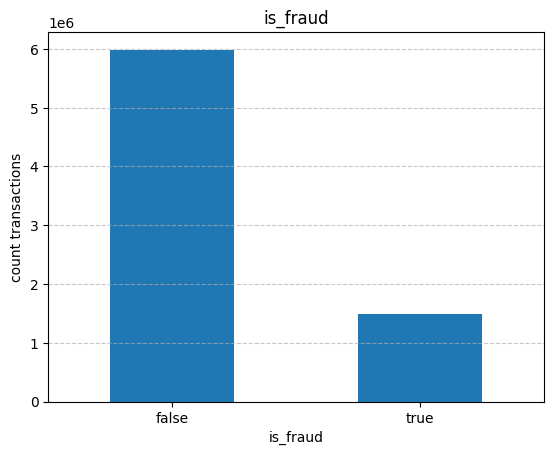

In [18]:
fraud_counts.plot(kind='bar')
plt.title('is_fraud')
plt.xticks(ticks=[0,1], labels=['false', 'true'], rotation=0)
plt.ylabel('count transactions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [16]:
# вендор

C:\Users\maksaid1972\AppData\Local\Temp\ipykernel_12160\1821672432.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cat_fraud.index, rotation=45, ha='right')


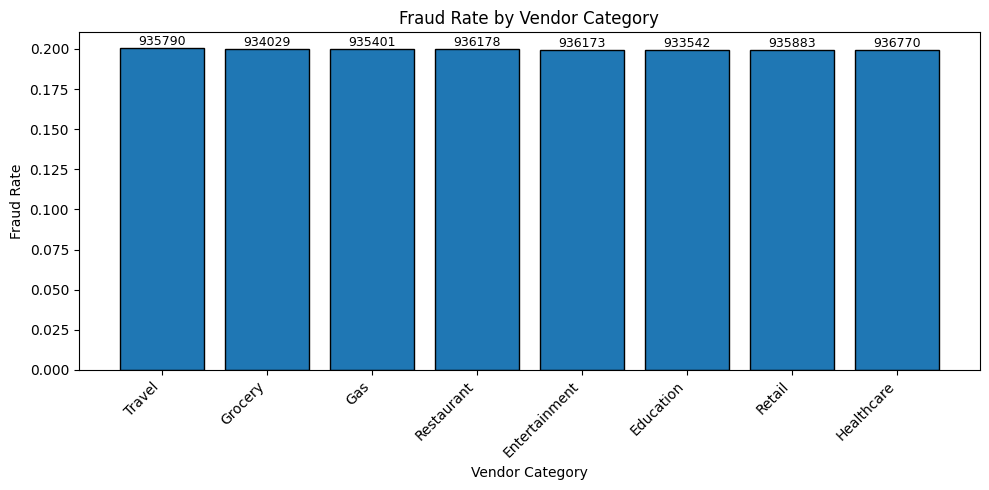

In [20]:
plot_fraud_by_category(transactions)

C:\Users\maksaid1972\AppData\Local\Temp\ipykernel_12160\1821672432.py:276: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vendor_type_fraud.index, rotation=45, ha='right')


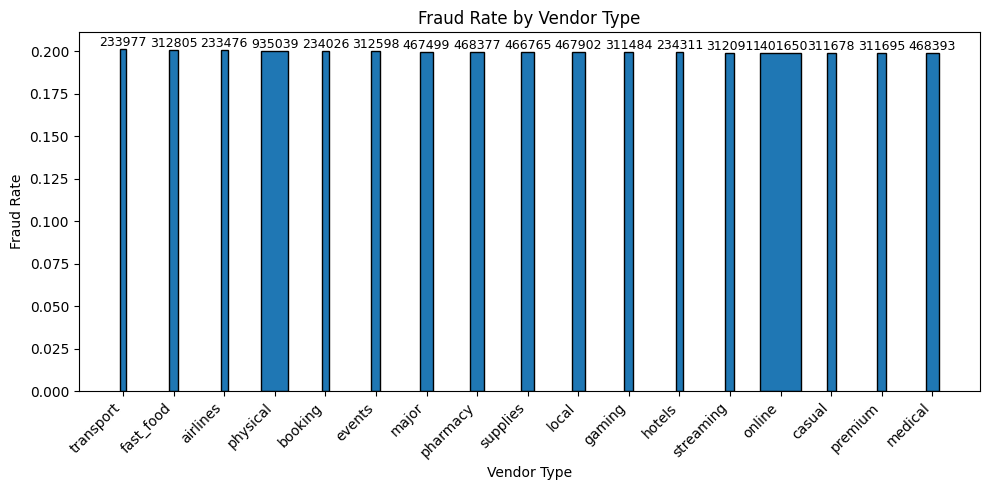

In [21]:
plot_fraud_by_vendor_type(transactions)

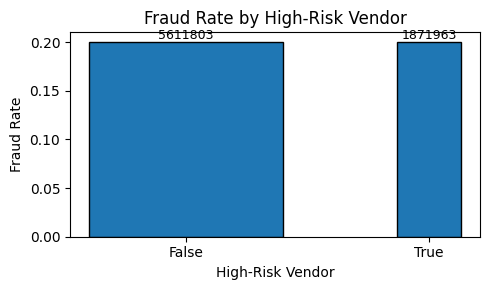

In [22]:
plot_fraud_by_high_risk_vendor(transactions)

In [20]:
# device 

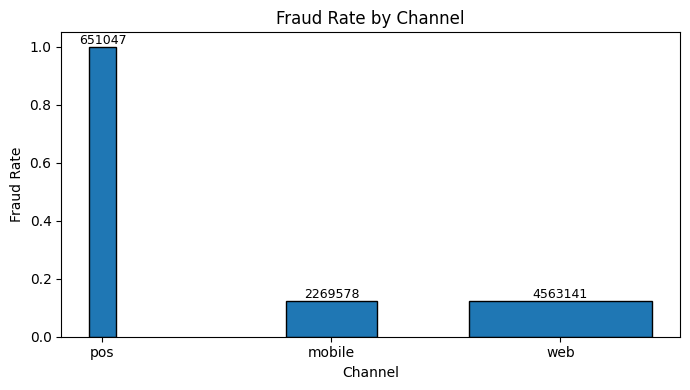

In [23]:
plot_fraud_by_channel(transactions)

In [24]:
transactions[transactions['channel'] == 'pos']['is_fraud'].value_counts()

is_fraud
True    651047
Name: count, dtype: int64

In [25]:
transactions[transactions['channel'] == 'pos'].shape

(651047, 31)

In [26]:
transactions[transactions['channel'] == 'pos']['is_fraud'].isna().sum()

np.int64(0)

In [27]:
transactions[transactions['channel'] == 'pos']['is_fraud'].unique()

array([ True])

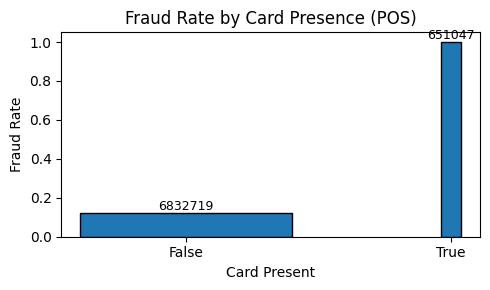

In [28]:
plot_fraud_by_card_presence(transactions)

C:\Users\maksaid1972\AppData\Local\Temp\ipykernel_12160\1821672432.py:300: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(device_fraud.index, rotation=45, ha='right')


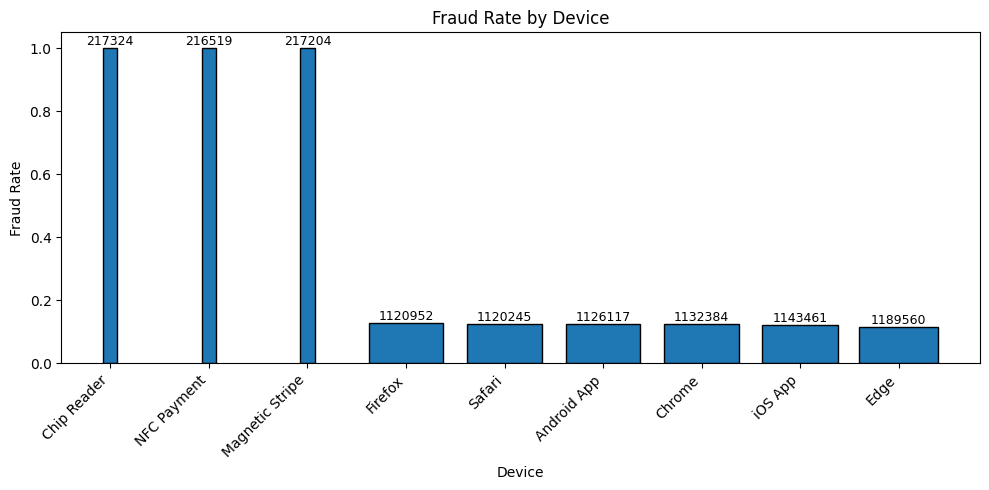

In [29]:
plot_fraud_by_device(transactions)

In [28]:
# time

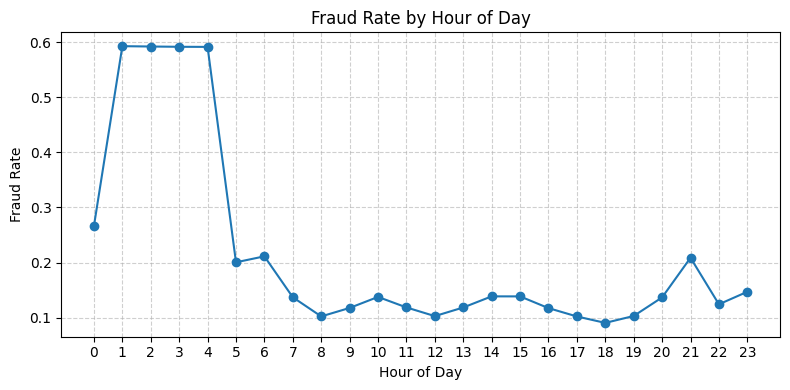

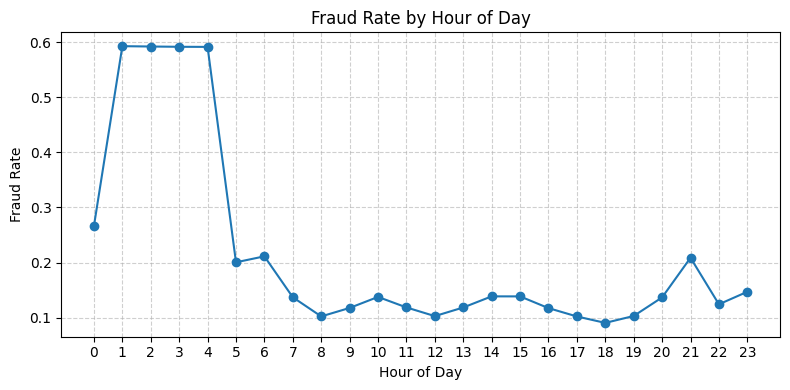

In [34]:
plot_fraud_by_hour(transactions)

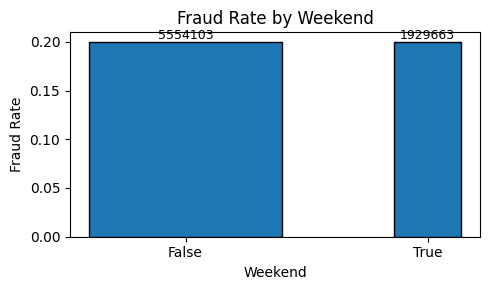

In [35]:
plot_fraud_by_weekend(transactions)

In [31]:
# activity

In [36]:
transactions.columns

Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'is_card_present',
       'device', 'channel', 'device_fingerprint', 'ip_address',
       'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend',
       'is_fraud', 'last_hour_num_transactions', 'last_hour_total_amount',
       'last_hour_unique_merchants', 'last_hour_unique_countries',
       'last_hour_max_single_amount', 'amount_usd',
       'last_hour_total_amount_usd', 'last_hour_max_single_amount_usd',
       'hour'],
      dtype='object')

C:\Users\maksaid1972\AppData\Local\Temp\ipykernel_12160\746196576.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lha_group = df.groupby('last_hour_num_transactions_bin')


[0.1796053  0.19847963 0.19981558 0.20047627 0.20075552 0.20314281
 0.21715228]


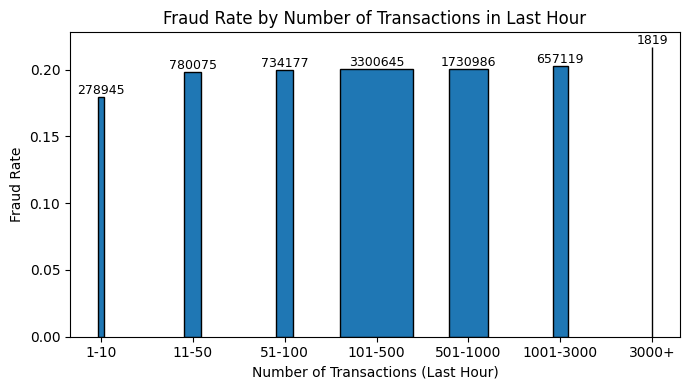

In [37]:
plot_fraud_by_last_hour_activity(transactions)

In [34]:
# amount

C:\Users\maksaid1972\AppData\Local\Temp\ipykernel_12160\746196576.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amt_group = df.groupby('amount_usd_bin')


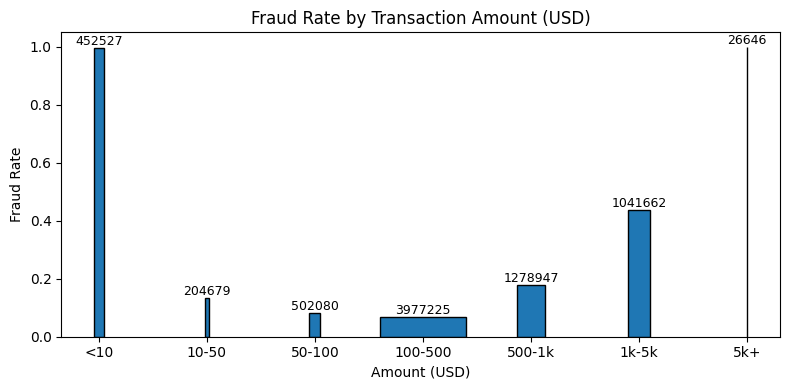

In [38]:
plot_fraud_by_amount_usd(transactions)

In [36]:
# card

C:\Users\maksaid1972\AppData\Local\Temp\ipykernel_12160\746196576.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(card_fraud.index, rotation=45, ha='right')


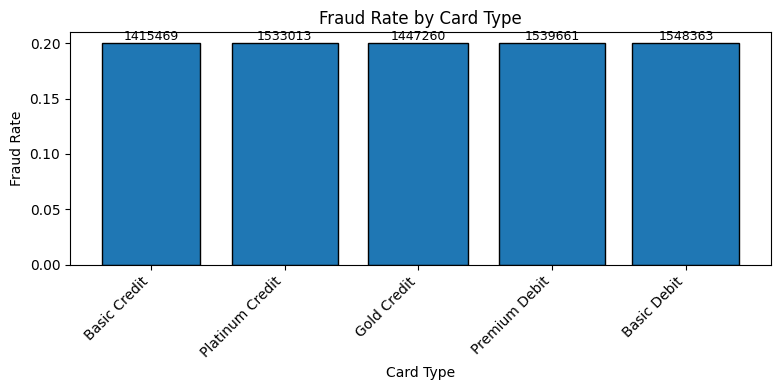

In [39]:
plot_fraud_by_card_type(transactions)

In [38]:
# geography

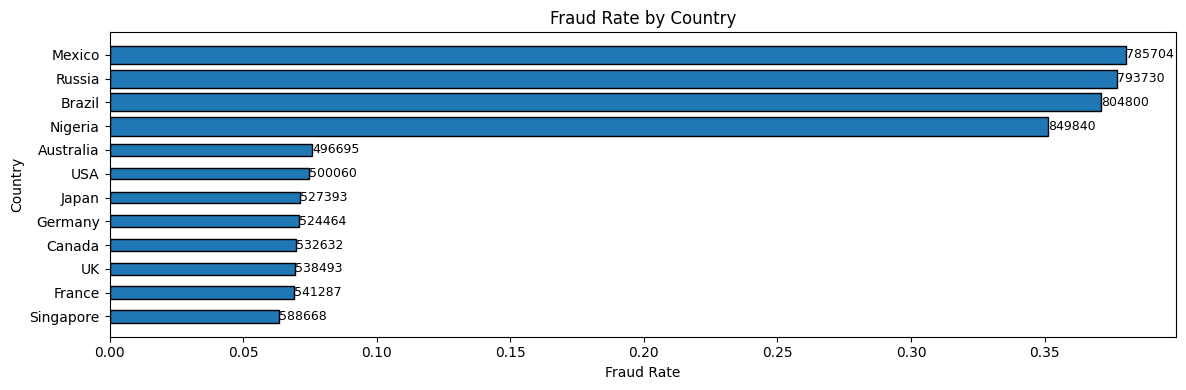

In [40]:
plot_fraud_by_country_bar(transactions)

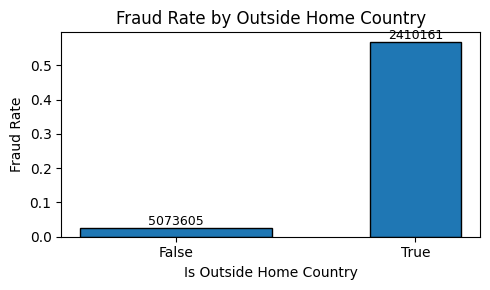

In [41]:
plot_fraud_by_outside_home_country_bar(transactions)

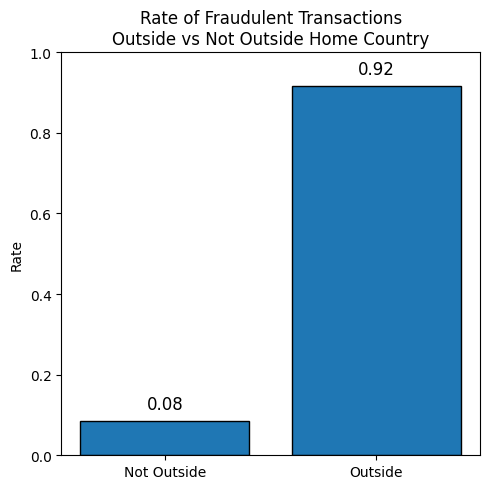

In [42]:
plot_outside_home_country_rate_for_fraud(transactions)